# Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance
*presented at: 2017 IEEE PVSC-44*
*by: Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball*

## Analysis
Predicting irradiance is crucial for developing solar power systems. Clear sky models are used to predict irradiance based on solar position and atmospheric data. This paper compares clear sky predictions using atmospheric data from ECMWF with irradiance measurments from SURFRAD. This notebook presents the analysis for the paper and presentation given by the authors at the 2017 IEEE PVSC-44 in Washingtion DC June 25-30th.

### ECMWF
The European Center for Medium Weather Forecast hosts datasets for the EU Copernicus MACC clearsky model. This data set contains aerosol optical depth and total column water vapor data derived from ground measurments and satelite data for the entire globe from 2003 to 2012.

### SURFRAD
SURFRAD data can be viewed online or downloaded from a NOAA FTP site <ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/>.

In [59]:
# imports
from datetime import datetime
from ftplib import FTP
import logging
from StringIO import StringIO

import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# set figure size
sns.set_context('notebook', rc={'figure.figsize': (16, 8)})

# logging
logging.basicConfig()
LOGGER = logging.getLogger('pvsc44-clearsky-aod')
LOGGER.setLevel(logging.DEBUG)


In [65]:
# Get SURFRAD data from NOAA

TESTING = True  # flag for testing
ECMWF_MACC_START = 2003
ECMWF_MACC_STOP = 2012
NOAA_FTP = 'aftp.cmdl.noaa.gov'
SURFRAD_PATH = '/'.join(['data', 'radiation', 'surfrad'])
SURFRAD_SITES = {'Bondville_IL': 'bon', 'Boulder_CO': 'tbl', 'Desert_Rock_NV': 'dra', 'Fort_Peck_MT': 'fpk',
                 'Goodwin_Creek_MS': 'gwn', 'Penn_State_PA': 'psu', 'Sioux_Falls_SD': 'sxf'}
# these sites have data outside of the time range of the atmospheric measurements
TOO_SOON = 'Alamosa_CO', 'Red_Lake_AZ', 'Rutland_VT', 'Wasco_OR'
DTYPES = [int, int, int, int, int, int, float, float, float, int, float, int, float, int, float, int, float, int, float, int,
          float, int, float, int, float, int, float, int, float, int, float, int, float, int, float, int, float, int, float, int,
          float, int, float, int, float, int, float, int]
NAMES = ['year', 'jday', 'month', 'day', 'hour', 'min', 'dt', 'zen', 'dw_solar', 'qc_dwsolar', 'uw_solar', 'qc_uwsolar',
         'direct_n', 'qc_direct_n', 'diffuse', 'qc_diffuse', 'dw_ir', 'qc_dwir', 'dw_casetemp', 'qc_dwcasetemp',
         'dw_dometemp', 'qc_dwdometemp', 'uw_ir', 'qc_uwir', 'uw_casetemp', 'qc_uwcasetemp', 'uw_dometemp', 'qc_uwdometemp',
         'uvb', 'qc_uvb', 'par', 'qc_par', 'netsolar', 'qc_netsolar', 'netir', 'qc_netir', 'totalnet', 'qc_totalnet',
         'temp', 'qc_temp', 'rh', 'qc_rh', 'windspd', 'qc_windspd', 'winddir', 'qc_winddir', 'pressure', 'qc_pressure']

noaa_ftp_conn = FTP(NOAA_FTP)  # connection
noaa_ftp_conn.connect()  # if timedout
noaa_ftp_conn.login()  # as anonymous
noaa_ftp_conn.cwd(SURFRAD_PATH)  # navigate to surfrad folder

# loop over sites
data = {}
stations = {}
for surfrad_site, station_id in SURFRAD_SITES.iteritems():
    noaa_ftp_conn.cwd(surfrad_site)  # open site folder
    years = []  # get list of available years
    noaa_ftp_conn.retrlines('NLST', lambda _: years.append(_))
    # loop over yearly site data
    for y in years:
        # skip any non-year items in the folder
        try:
            year = int(y)
        except ValueError:
            continue
        # limit to data overlapping ECMWF atmospheric data (for now)
        if ECMWF_MACC_START <= year <= ECMWF_MACC_STOP:
            noaa_ftp_conn.cwd(y)  # open site folder
            files = []  # get list of available daily datafiles
            noaa_ftp_conn.retrlines('NLST', lambda _: files.append(_))
            for f in files:
                LOGGER.debug('file: %s', f)
                buf = StringIO()  # buffer is a Python builtin, **SURPRISE!**
                noaa_ftp_conn.retrbinary('RETR %s' % f, buf.write)
                buf.seek(0)
                station_name = buf.readline().strip()
                latitude, longitude, elevation, _ = buf.readline().split(None, 3)
                if station_id not in stations:
                    stations[station_id] = [(year, f, station_name, float(latitude), float(longitude), float(elevation))]
                else:
                    stations[station_id].append((year, f, station_name, float(latitude), float(longitude), float(elevation)))
                df = pd.read_table(buf, names=NAMES, dtype=zip(NAMES, DTYPES), delim_whitespace=True,
                                   parse_dates=[['year', 'month', 'day', 'hour', 'min']],
                                   date_parser=lambda y, mo, d, h, m: datetime(y, mo, d, h, m),
                                   na_values='-9999.9', index_col='year_month_day_hour_min')
                if station_id not in data:
                    data[station_id] = df
                else:
                    data[station_id] = data[station_id].append(df)
            noaa_ftp_conn.cwd('..')  # open site folder
            data_array = data[station_id].to_records()
            data_array = data_array.astype(np.dtype(
                [('year_month_day_hour_min', str, 30)]
                + [(str(n), d) for n, d in data_array.dtype.descr if n != 'year_month_day_hour_min']
            ))
            try:
                with h5py.File('%s-%d.h5' % (station_id, year)) as h5f: h5f['data'] = data_array
            except RuntimeError:
                pass


DEBUG:pvsc44-clearsky-aod:file: sxf03166.dat


![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)
Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance by [Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball](https://github.com/mikofski/pvsc44-clearsky-aod) is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).


In [66]:
data['sxf']

,jday,dt,zen,dw_solar,qc_dwsolar,uw_solar,qc_uwsolar,direct_n,qc_direct_n,diffuse,...,temp,qc_temp,rh,qc_rh,windspd,qc_windspd,winddir,qc_winddir,pressure,qc_pressure
year_month_day_hour_min,,,,,,,,,,,,,,,,,,,,,
2003-06-15 00:30:00,166,0.50,74.39,61.6,0,11.9,0,14.7,0,67.6,...,27.1,0,27.2,0,1.8,0,3.4,0,961.9,0
2003-06-15 00:33:00,166,0.55,74.90,53.4,0,9.7,0,2.3,0,63.6,...,27.0,0,26.9,0,1.5,0,356.8,0,961.8,0
2003-06-15 00:36:00,166,0.60,75.42,51.7,0,9.5,0,1.3,0,61.8,...,27.0,0,26.3,0,1.6,0,353.3,0,961.8,0
2003-06-15 00:39:00,166,0.65,75.93,50.3,0,9.5,0,3.2,0,60.0,...,27.0,0,26.8,0,1.2,0,350.2,0,961.8,0
2003-06-15 00:42:00,166,0.70,76.44,49.6,0,9.2,0,4.0,0,58.2,...,26.9,0,27.4,0,1.0,0,30.8,0,961.8,0
2003-06-15 00:45:00,166,0.75,76.94,48.8,0,8.6,0,5.3,0,56.6,...,26.8,0,28.3,0,1.2,0,54.1,0,961.8,0
2003-06-15 00:48:00,166,0.80,77.45,48.4,0,8.6,0,4.3,0,56.4,...,26.8,0,28.6,0,0.9,0,39.4,0,961.8,0
2003-06-15 00:51:00,166,0.85,77.95,48.1,0,8.6,0,3.8,0,55.8,...,26.7,0,29.0,0,0.9,0,49.3,0,961.8,0
2003-06-15 00:54:00,166,0.90,78.46,45.7,0,8.0,0,6.5,0,52.8,...,26.7,0,29.0,0,0.9,0,53.8,0,961.8,0


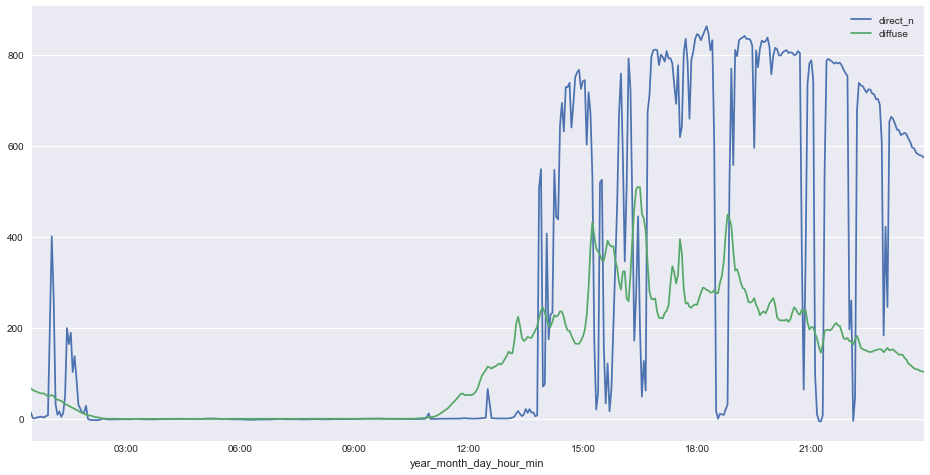

In [67]:
data['sxf'][['direct_n', 'diffuse']].plot()

In [68]:
print '%s (%g x %g x %g[m])' % (station_name, float(latitude), float(longitude), float(elevation))

Sioux Falls (43.73 x -96.62 x 473[m])


In [70]:
stations['sxf']

[(2003, 'sxf03166.dat', 'Sioux Falls', 43.73, -96.62, 473.0)]